In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import datetime as dt
import statsmodels as sm
from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import warnings
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

In [5]:
colors = sns.color_palette("Paired")

# Read data

In [45]:
drivers = pd.read_csv("../data/drivers.csv")
pings = pd.read_csv("../data/pings.csv")
test = pd.read_csv("../data/test.csv")

In [46]:
pings = pings.sort_values(['driver_id', 'ping_timestamp'], ascending=[True, True])

In [47]:
pings.head()

,driver_id,ping_timestamp
1315,111556,1496279340
1388,111556,1496279355
1453,111556,1496279370
1593,111556,1496279400
1749,111556,1496279430


In [48]:
drivers.head()

,driver_id,gender,age,number_of_kids
0,979863,MALE,26,2
1,780123,MALE,60,2
2,614848,MALE,45,4
3,775046,MALE,62,3
4,991601,MALE,23,0


In [49]:
test.head()

,driver_id,date,online_hours
0,979863,2017-6-28,7
1,979863,2017-6-27,9
2,979863,2017-6-26,9
3,979863,2017-6-25,10
4,979863,2017-6-24,9


### Check if the same drivers are in test and driver tables (no need)

In [50]:
print(len(test.driver_id.unique()))
print(len(drivers.driver_id.unique()))
sorted(test.driver_id.unique()) == sorted(drivers.driver_id.unique())

2497
2497


True

### Check for Nulls

In [9]:
drivers.isnull().any()

driver_id         False
gender            False
age               False
number_of_kids    False
dtype: bool

In [10]:
pings.isnull().any()

driver_id         False
ping_timestamp    False
dtype: bool

In [11]:
test.isnull().any()

driver_id       False
date            False
online_hours    False
dtype: bool

### Check for data quality in drivers table. 
We expect unique values for all driver ids.


In [51]:
len(drivers.driver_id.unique())
d = drivers.driver_id.value_counts()
print("Driver IDS of drivers whose id appeared more than once")
print(d[d > 1])
ids = d[d > 1].index.tolist()
drivers[drivers['driver_id'].isin(ids)]

Driver IDS of drivers whose id appeared more than once
800600    2
320227    2
799250    2
Name: driver_id, dtype: int64


,driver_id,gender,age,number_of_kids
231,320227,MALE,22,4
388,320227,MALE,42,4
1311,799250,FEMALE,27,4
1550,800600,FEMALE,22,0
1765,799250,FEMALE,23,0
2008,800600,FEMALE,28,1


Looks like there is inconsistency in the drivers table. As its not just duplicates of the driver_id but also inconsistency in the age and number of kids, lets drop these rows containing these ids since they are quite few and we dont know which is the true value 

These ids will automatically be removed as well from drivers when a join is done

In [52]:
ids

[800600, 320227, 799250]

In [53]:
drivers = drivers[~drivers['driver_id'].isin(ids)]
# test = test[~test['driver_id'].isin(ids)]

In [54]:
print(len(drivers))
# print(len(test.driver_id.unique()))
# sorted(test.driver_id.unique()) == sorted(drivers.driver_id.unique())

2494


# Transform data in pings DF

## Convert to datetime, extract date

In [55]:
# extract datetime and date as new columns 
pings['datetime'] = pd.to_datetime(pings.ping_timestamp, unit='s')
pings['date'] = pd.to_datetime(pings.datetime).dt.date

# convert 'date' column back to datetime format
pings['date'] = pd.to_datetime(pings['date'])

In [56]:
pings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50528701 entries, 1315 to 50519047
Data columns (total 4 columns):
driver_id         int64
ping_timestamp    int64
datetime          datetime64[ns]
date              datetime64[ns]
dtypes: datetime64[ns](2), int64(2)
memory usage: 1.9 GB


In [57]:
pings.head()

,driver_id,ping_timestamp,datetime,date
1315,111556,1496279340,2017-06-01 01:09:00,2017-06-01
1388,111556,1496279355,2017-06-01 01:09:15,2017-06-01
1453,111556,1496279370,2017-06-01 01:09:30,2017-06-01
1593,111556,1496279400,2017-06-01 01:10:00,2017-06-01
1749,111556,1496279430,2017-06-01 01:10:30,2017-06-01


In [58]:
pings['hour'] = pings['datetime'].dt.hour
pings.head()

,driver_id,ping_timestamp,datetime,date,hour
1315,111556,1496279340,2017-06-01 01:09:00,2017-06-01,1
1388,111556,1496279355,2017-06-01 01:09:15,2017-06-01,1
1453,111556,1496279370,2017-06-01 01:09:30,2017-06-01,1
1593,111556,1496279400,2017-06-01 01:10:00,2017-06-01,1
1749,111556,1496279430,2017-06-01 01:10:30,2017-06-01,1


### Quick exploratory analysis of activity by hour

In [59]:
# Perform an inner join on driver and pings
df_hour = pd.merge(drivers,pings,on = "driver_id")

In [60]:
df_hour.drop(columns=['ping_timestamp','datetime'], inplace=True)
df_hour.drop_duplicates(inplace=True)
df_hour.head()

,driver_id,gender,age,number_of_kids,date,hour
0,979863,MALE,26,2,2017-06-01,3
124,979863,MALE,26,2,2017-06-01,4
350,979863,MALE,26,2,2017-06-01,5
572,979863,MALE,26,2,2017-06-01,6
795,979863,MALE,26,2,2017-06-01,7


In [61]:
df_hour['age_group'] = pd.cut(df_hour['age'], [18, 30, 50,75])
df_hour.head()

,driver_id,gender,age,number_of_kids,date,hour,age_group
0,979863,MALE,26,2,2017-06-01,3,"(18, 30]"
124,979863,MALE,26,2,2017-06-01,4,"(18, 30]"
350,979863,MALE,26,2,2017-06-01,5,"(18, 30]"
572,979863,MALE,26,2,2017-06-01,6,"(18, 30]"
795,979863,MALE,26,2,2017-06-01,7,"(18, 30]"


### Segment activity by time of day  (hour) and gender

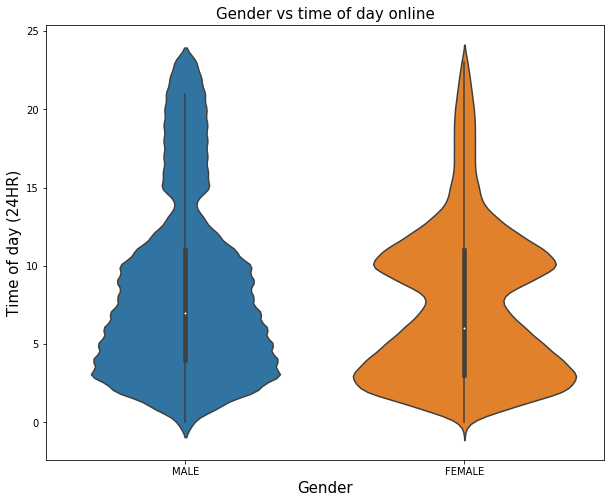

In [62]:
fig, ax = plt.subplots(figsize=(10,8)) # first plots set figure size for all other plots below
sns.violinplot(x='gender', y='hour', data=df_hour)
plt.title ('Gender vs time of day online', fontsize=15);
plt.xlabel('Gender', fontsize=15);
plt.ylabel( 'Time of day (24HR)', fontsize=15);

### Segment activity by time of day  (hour) and age bucket

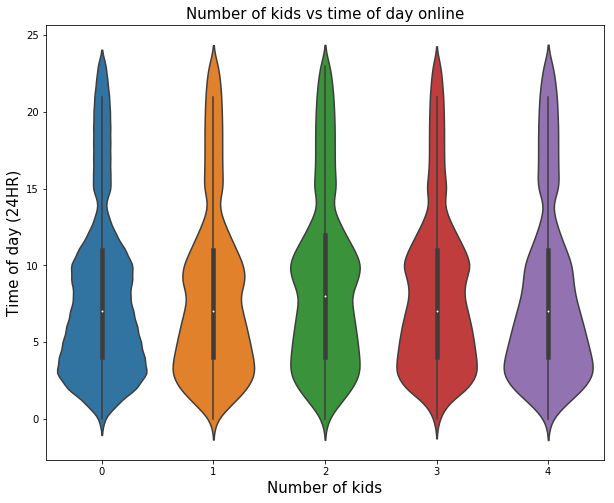

In [63]:
fig, ax = plt.subplots(figsize=(10,8))
sns.violinplot(x='number_of_kids', y='hour', data=df_hour)
plt.title ('Number of kids vs time of day online', fontsize=15);
plt.xlabel('Number of kids', fontsize=15);
plt.ylabel( 'Time of day (24HR)', fontsize=15);

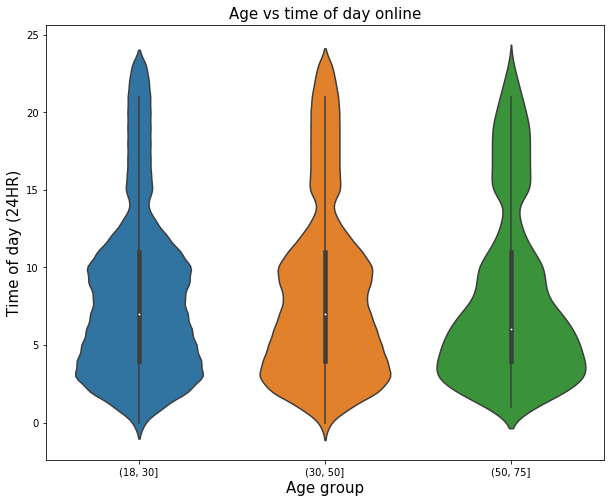

In [64]:
fig, ax = plt.subplots(figsize=(10,8))
sns.violinplot(x='age_group', y='hour', data=df_hour)
plt.title ('Age vs time of day online', fontsize=15);
plt.xlabel('Age group', fontsize=15);
plt.ylabel( 'Time of day (24HR)', fontsize=15);

## For each driver, for each day, get total number of hours spent online
- For each day, for each driver count the number of consecutive pings recieved that are 15s apart.
- Next, multiply that count by 15
- Then divide by 3600 to get the number of hours spent online per day


### Method to calculate number of consecutive 15s ping intervals

In [65]:
# Get number of 15s intervals that are consecutive
pings['timediff'] = pings.groupby(['driver_id','date'])['datetime'].diff() / np.timedelta64(1, 's')
y = pd.DataFrame(pings[pings['timediff']==15].groupby(['driver_id','date'],as_index=False)['timediff'].count())

In [66]:
# Do not round the online hours at this point even though test set has integer dtype for online hours 
y['online_hours'] = y['timediff']*15/3600

In [67]:
y = y.drop(columns=['timediff'],axis =1)
y.head(10)

,driver_id,date,online_hours
0,111556,2017-06-01,1.820833
1,111556,2017-06-02,2.050000
2,111556,2017-06-05,3.812500
3,111556,2017-06-06,2.470833
4,111556,2017-06-07,2.145833
5,111556,2017-06-08,2.600000
6,111556,2017-06-09,3.645833
7,111556,2017-06-12,3.008333
8,111556,2017-06-13,3.541667
9,111556,2017-06-14,1.570833


In [68]:
# Lets stick with pings as name
pings = y

### Do all driver ids in driver table appear in the pings table?
No, some driver ids in pings table do not exist in the drivers table but do nothing here as they will be removed with inner join

In [69]:
print("pings has %s unique drivers " %len(pings.driver_id.unique()))
p = pings.driver_id.unique()
print("drivers has %s unique drivers " %len(drivers.driver_id.unique()))
d = drivers.driver_id.unique()

pings has 2480 unique drivers 
drivers has 2494 unique drivers 


# Combine the drivers and new pings into new df

In [139]:
df1 = pd.merge(drivers,pings,on = "driver_id")
print(len(df1))

41612


In [140]:
df1 = df1.sort_values(['driver_id', 'date'], ascending=[True, True])

In [141]:
df1.head()

,driver_id,gender,age,number_of_kids,date,online_hours
408,111556,FEMALE,49,4,2017-06-01,1.820833
409,111556,FEMALE,49,4,2017-06-02,2.050000
410,111556,FEMALE,49,4,2017-06-05,3.812500
411,111556,FEMALE,49,4,2017-06-06,2.470833
412,111556,FEMALE,49,4,2017-06-07,2.145833


Note, not all drivers drive everyday of the 14 days. 
We need to normalize this to create the missing days in the data to match
the test data which has the next 7 days.

# Combine drivers and test tables into new df

In [581]:
test2 = pd.merge(test,drivers,on = 'driver_id')

# Check data

In [90]:
pandas_profiling.ProfileReport(df1)

Number of variables,7
Number of observations,41612
Total Missing (%),0.0%
Total size in memory,2.2 MiB
Average record size in memory,56.0 B
Numeric,5
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,0


Looks like there is no missing data

In [109]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41612 entries, 0 to 41611
Data columns (total 8 columns):
driver_id           41612 non-null int64
gender              41612 non-null object
age                 41612 non-null int64
number_of_kids      41612 non-null int64
date                41612 non-null object
online_hours        41612 non-null float64
day_of_week         41612 non-null int64
day_of_week_name    41612 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 2.5+ MB


# Feature engineering
Since date is expandable for feature engineering, we will use that to get more info 

In [142]:
df1['date'] = pd.to_datetime(df1['date'])

In [143]:
# Lets get day of week from the date
# 0 is Monday, 6 is Sunday
df1['day_of_week'] = df1['date'].dt.dayofweek

In [144]:
# Lets get day of week name from the date
df1['day_of_week_name'] = df1['date'].dt.weekday_name

In [145]:
# map gender to category
df1['gender'] = df1['gender'].map( {'MALE':1, 'FEMALE':0} )

 ## Normalize dates for drivers

In [463]:
df1.head()

,driver_id,gender,age,number_of_kids,date,online_hours,day_of_week,day_of_week_name
408,111556,0,49,4,2017-06-01,1.820833,3,Thursday
409,111556,0,49,4,2017-06-02,2.050000,4,Friday
410,111556,0,49,4,2017-06-05,3.812500,0,Monday
411,111556,0,49,4,2017-06-06,2.470833,1,Tuesday
412,111556,0,49,4,2017-06-07,2.145833,2,Wednesday


Some drivers have missing dates from the 14 days. 

### Cehck if all drivers have all 7 days in test

In [582]:
s = test2.groupby('driver_id')['date'].count()
s2 = [i for i in s if i != 7]
if len(s2) == 0:
    print("all drivers have all 7 days of test data")
else:
    print("test data has quality issue")

all drivers have all 7 days of test data


All the drivers have 7 consecutive days of test data.
This means we should have all consecutive 14 days for all drivers as well Ieven if they didnt drive all 14 days)

In [496]:
def create_norm_df(df):
    df_list = []
    cols = ['driver_id', 'gender', 'age', 'number_of_kids']
    unique_drivers = df.driver_id.unique()

    for i in unique_drivers:
        tmp = df[df.driver_id ==i]
        tmp = tmp.set_index('date')
        #create daily driver stats per driver, even if they didnt drive that day
        tmp = tmp.reindex(pd.DatetimeIndex(start=pd.to_datetime('2017-06-01'), end=pd.to_datetime('2017-06-21'), freq='D'))
        # replace nulls for driver stats with max row value, ignored Nulls, infers int
        tmp[cols] = tmp[cols].fillna(tmp[cols].max(), downcast='infer')
        # For online hours, fill NAN to 0
        tmp['online_hours'] = tmp['online_hours'].fillna(0)
        #Replace nan to day of week based on the indexed date
        tmp = tmp.reset_index()
        tmp.rename(columns={'index':'date'},inplace=True)
        tmp['day_of_week'] = pd.to_datetime(tmp['date']).dt.dayofweek
        tmp['day_of_week_name'] = pd.to_datetime(tmp['date']).dt.weekday_name
        #append dataframe to list
        df_list.append(tmp)
    
    #Merge all tmp dataframes into 1
    df_reindexed = pd.concat(df_list)
    df_reindexed[cols] = df_reindexed[cols].apply(lambda x: x.astype(int))
    return df_reindexed

In [494]:
df2 = create_norm_df(df1)   

In [495]:
df2.head()

,date,driver_id,gender,age,number_of_kids,online_hours,day_of_week,day_of_week_name
0,2017-06-01,111556,0,49,4,1.820833,3,Thursday
1,2017-06-02,111556,0,49,4,2.050000,4,Friday
2,2017-06-03,111556,0,49,4,0.000000,5,Saturday
3,2017-06-04,111556,0,49,4,0.000000,6,Sunday
4,2017-06-05,111556,0,49,4,3.812500,0,Monday


In [497]:
df2.to_csv('../data/df2.csv',index=False)

In [585]:
df2 = pd.read_csv('../data/df2.csv')

# Exploratory Data Analysis

- male vs female
- age distribution
- number of kids distribution
- number of hours online males vs female
- number of hours online by age
- number of hours online by number of kids
- average number of hours online per day for each day
- average number of hours online by day of week
- avg number of hours per day if x kids
- avg number of hours by day of week, number of kids

MALE      0.758621
FEMALE    0.241379
Name: gender, dtype: float64


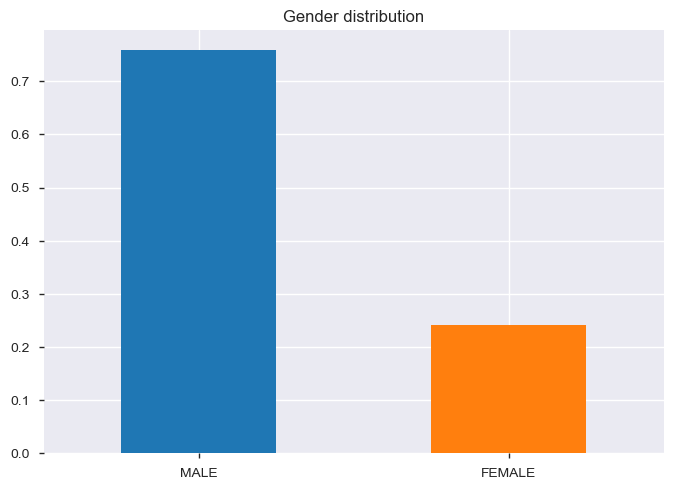

In [499]:
print(drivers.gender.value_counts(normalize=True))
drivers.gender.value_counts(normalize=True).plot(kind = 'bar', title = 'Gender distribution',rot = 0)

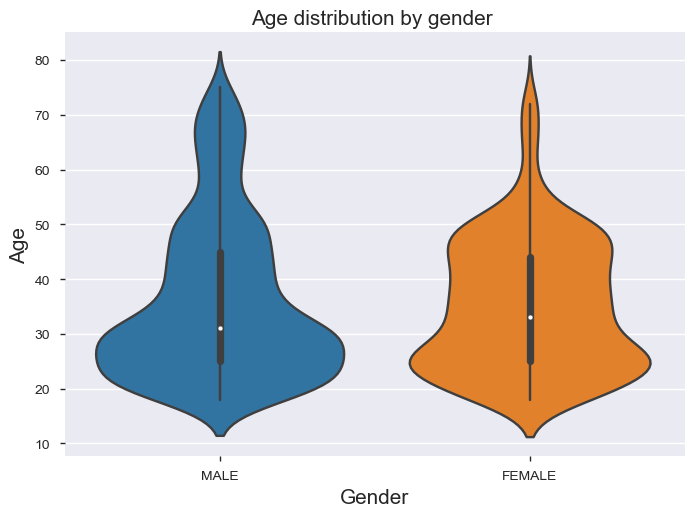

In [500]:
sns.violinplot(x='gender', y='age', data=drivers)
plt.title ('Age distribution by gender ', fontsize=15);
plt.xlabel('Gender', fontsize=15);
plt.ylabel('Age', fontsize=15);

Text(0.5, 1.0, 'Overall driver age distribution')

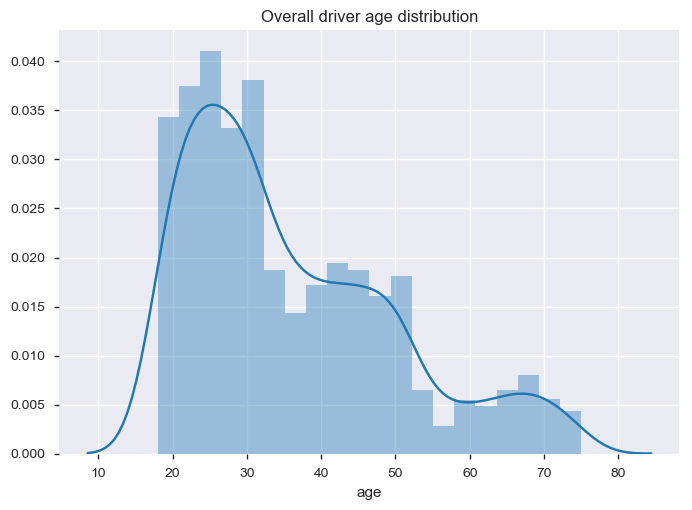

In [501]:
# drivers.age.plot(kind = 'hist', title = 'Age distribution',rot =0, bins = 20)
sns.distplot(drivers.age)
plt.title('Overall driver age distribution')

Text(0.5, 1.0, 'Male Age Dist')

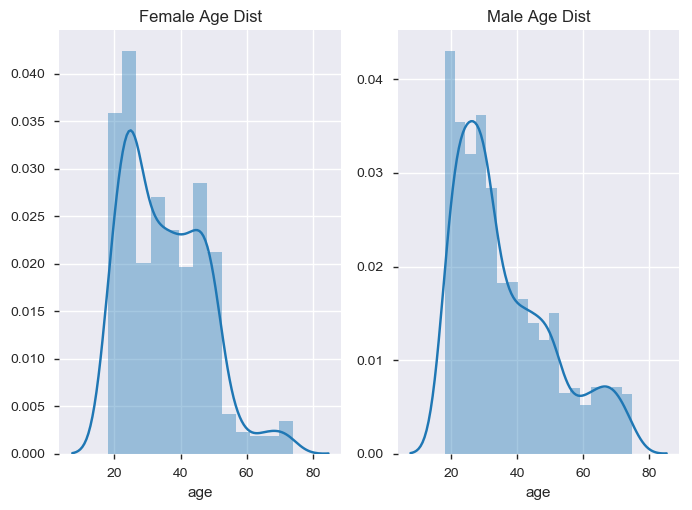

In [502]:
# drivers.age.plot(kind = 'hist', title = 'Age distribution',rot =0, bins = 20)
fig,ax = plt.subplots(1, 2)
sns.distplot(drivers[drivers['gender']=='FEMALE']['age'],ax = ax[0],kde=True)
ax[0].set_title('Female Age Dist')
sns.distplot(drivers[drivers['gender']=='MALE']['age'],ax = ax[1],kde=True)
ax[1].set_title('Male Age Dist')

Text(0, 0.5, 'Driver count')

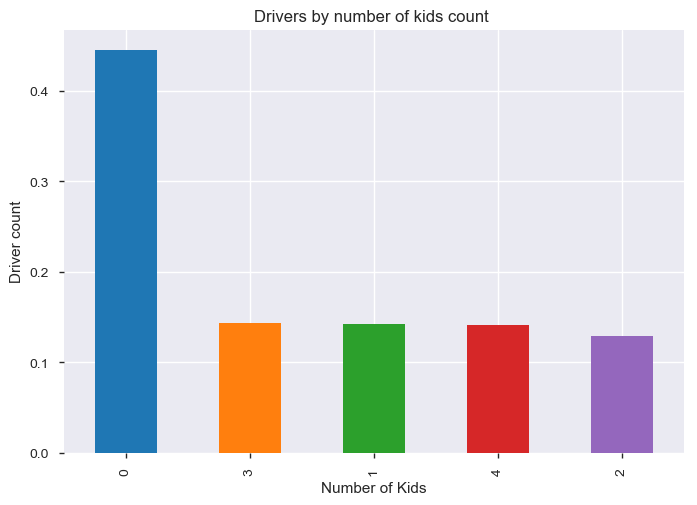

In [503]:
drivers.number_of_kids.value_counts(normalize = True).plot(kind = 'bar',title = "Drivers by number of kids count ")
plt.xlabel("Number of Kids")
plt.ylabel("Driver count")

### Lets look at average hours online by driver,gender,age,kids and remove day

In [504]:
x1 = df2.groupby(['driver_id','gender','age','number_of_kids'], as_index=False).agg({'online_hours':'mean'})
x1['online_hours'] = round(x1['online_hours'])
x1['age_group'] = pd.cut(x1['age'], [18, 30, 50,75])
x1.head()

,driver_id,gender,age,number_of_kids,online_hours,age_group
0,111556,0,49,4,2.0,"(30, 50]"
1,111575,1,49,0,3.0,"(30, 50]"
2,111779,1,26,0,2.0,"(18, 30]"
3,111839,1,25,0,6.0,"(18, 30]"
4,112486,0,44,1,2.0,"(30, 50]"


### Average hours online segmented by Male and Female

In [506]:
x2 = x1.groupby(['gender'], as_index=False).agg({'online_hours':'mean'})
x2.head()

,gender,online_hours
0,0,2.277409
1,1,4.060800


### KDE plot of Female VS Male online hours

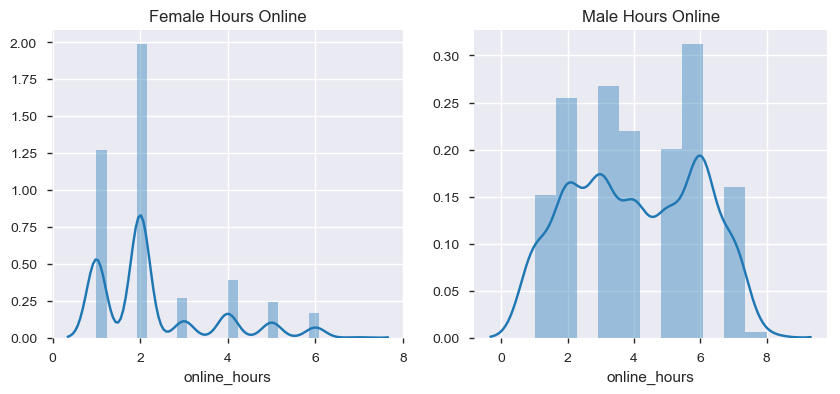

In [590]:
fig,ax = plt.subplots(1, 2,figsize=(10,4))
F = x1[x1['gender']==0]['online_hours']
M = x1[x1['gender']==1]['online_hours']
sns.distplot(F,ax = ax[0],kde=True)
sns.distplot(M,ax = ax[1],kde=True)
ax[0].set_title('Female Hours Online');
ax[1].set_title('Male Hours Online');

In [508]:
M_norm = pd.DataFrame(M.value_counts(normalize=True))
F_norm = pd.DataFrame(F.value_counts(normalize=True))

In [509]:
M_norm.reset_index(inplace=True)

In [510]:
F_norm.reset_index(inplace=True)

In [511]:
pd.merge(M_norm,F_norm, on ='index', how ='outer',suffixes=('_Male', '_Female'))

,index,online_hours_Male,online_hours_Female
0,6.0,0.198400,0.038206
1,3.0,0.170133,0.061462
2,2.0,0.162133,0.458472
3,4.0,0.139733,0.089701
4,5.0,0.127467,0.056478
5,7.0,0.101867,0.001661
6,1.0,0.096533,0.294020
7,8.0,0.003733,NaN


Females tend to spend shorter time online than males, mostly between 2-3 hours, and no more than 7 hours

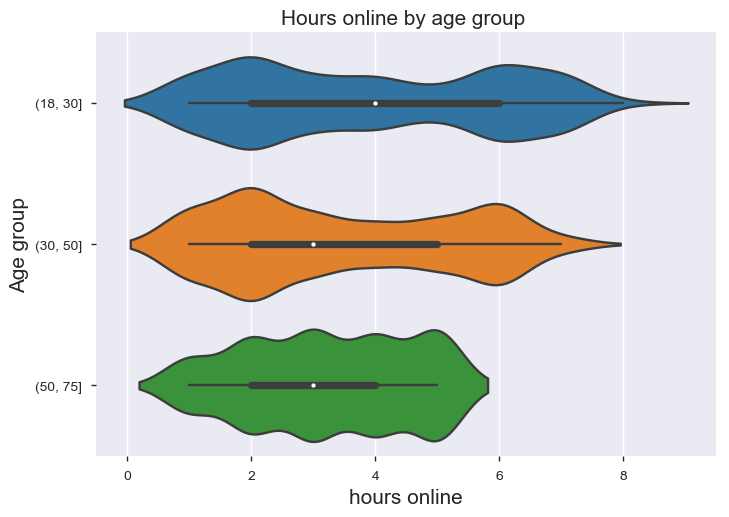

In [512]:
sns.violinplot(x='online_hours', y='age_group', data=x1)
plt.title ('Hours online by age group ', fontsize=15);
plt.xlabel('hours online', fontsize=15);
plt.ylabel('Age group', fontsize=15);

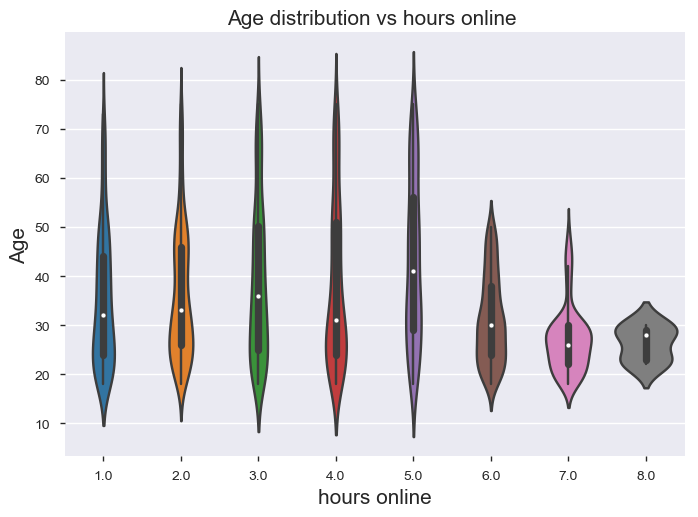

In [513]:
sns.violinplot(x='online_hours', y='age', data=x1)
plt.title ('Age distribution vs hours online ', fontsize=15);
plt.xlabel('hours online', fontsize=15);
plt.ylabel('Age', fontsize=15);


- Older drivers (50 and above) spend usually 5 hours online
- Drivers between 20-35 driver very long hours (7-8 hours)

In [514]:
x1.head()

,driver_id,gender,age,number_of_kids,online_hours,age_group
0,111556,0,49,4,2.0,"(30, 50]"
1,111575,1,49,0,3.0,"(30, 50]"
2,111779,1,26,0,2.0,"(18, 30]"
3,111839,1,25,0,6.0,"(18, 30]"
4,112486,0,44,1,2.0,"(30, 50]"


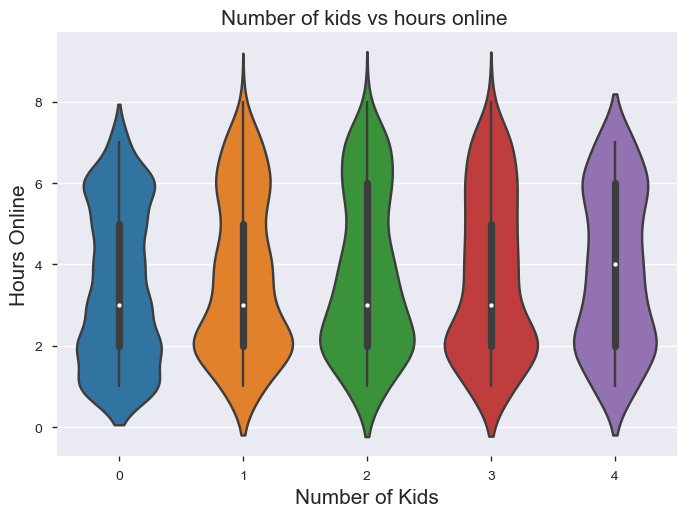

In [515]:
sns.violinplot(x='number_of_kids', y= 'online_hours', data=x1)
# sns.violinplot(x='online_hours', y= 'number_of_kids', data=x1)
plt.title ('Number of kids vs hours online ', fontsize=15);
plt.xlabel('Number of Kids', fontsize=15);
plt.ylabel('Hours Online', fontsize=15);

Drivers with 4 kids tend to spend more time online than those with less kids

In [516]:
df1.head()
df1.info()
df1.date = pd.to_datetime(df1.date)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41612 entries, 408 to 22890
Data columns (total 8 columns):
driver_id           41612 non-null int64
gender              41612 non-null int64
age                 41612 non-null int64
number_of_kids      41612 non-null int64
date                41612 non-null datetime64[ns]
online_hours        41612 non-null float64
day_of_week         41612 non-null int64
day_of_week_name    41612 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.9+ MB


Text(0.5, 1.0, 'Number of drivers per day')

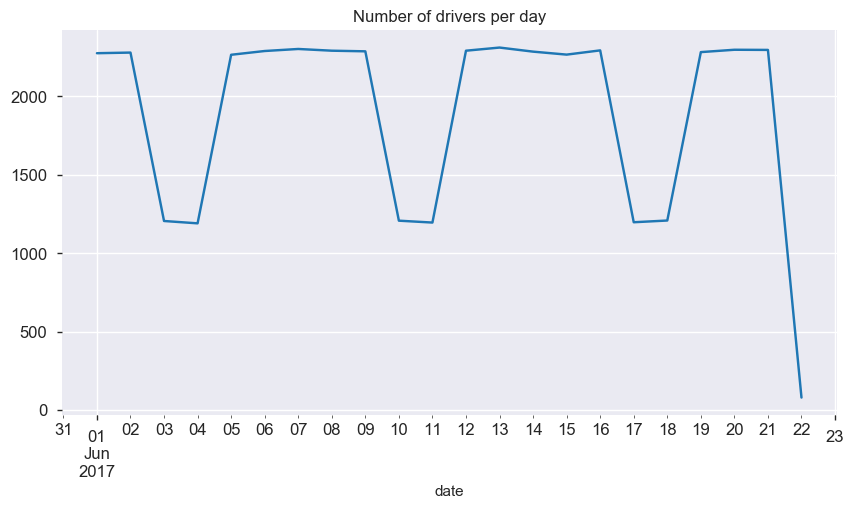

In [517]:
num_drivers_per_day = df1.groupby(['date'], as_index=False).agg({'driver_id':'count'})
num_drivers_per_day.plot(x='date',y ='driver_id', kind = 'line', figsize=(10,5), fontsize=12,legend = False)
plt.title('Number of drivers per day')

seasonality exist

         date  online_hours
0  2017-06-01      3.912756
1  2017-06-02      3.927875
2  2017-06-03      2.789741
3  2017-06-04      2.801485
4  2017-06-05      3.872110


Text(0.5, 1.0, 'Avg online hours per day')

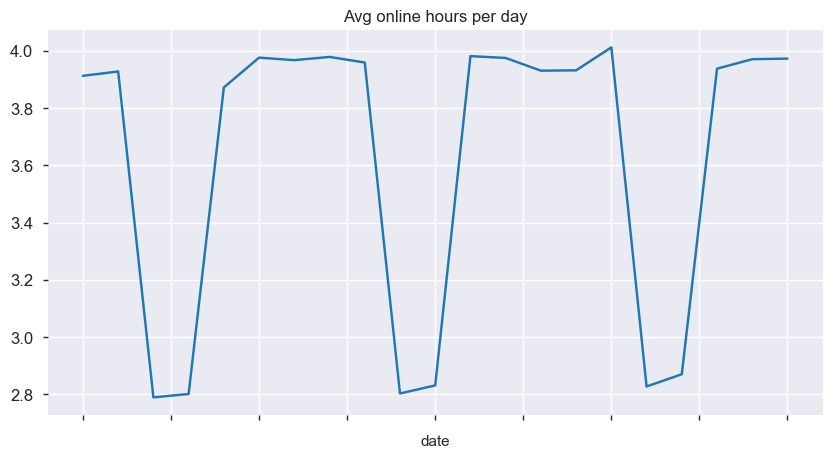

In [586]:
avg_hours_per_day = df2.groupby(['date'], as_index=False).agg({'online_hours':'mean'})
print(avg_hours_per_day.head())
avg_hours_per_day.plot(x='date',y ='online_hours', kind = 'line', figsize=(10,5), fontsize=12,legend=False,rot=45)
plt.title('Avg online hours per day')

Weekends has lower average online hours than weekdays. Less drivers

  day_of_week_name  online_hours
0           Friday      3.966379
1           Monday      3.930446
2         Saturday      2.806914
3           Sunday      2.834512
4         Thursday      3.941103
5          Tuesday      3.974057
6        Wednesday      3.956978


Text(0.5, 1.0, 'Average Hours Online by Day of Week')

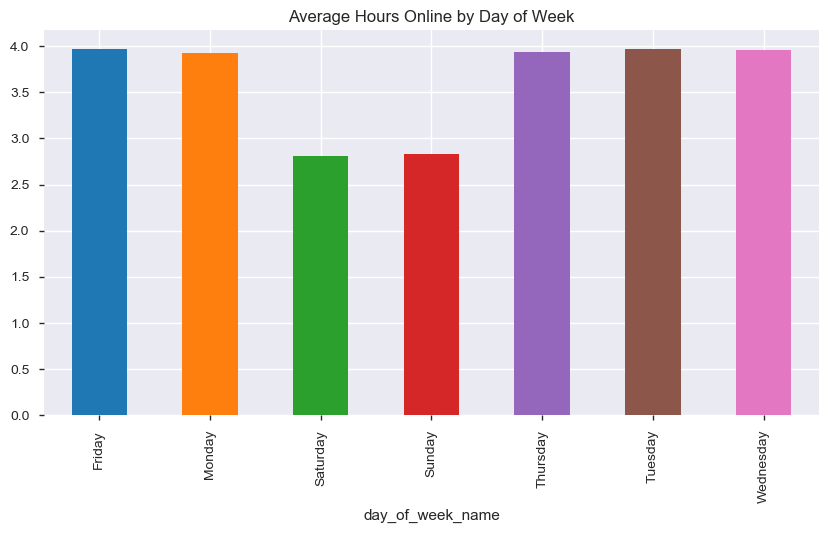

In [587]:
avg_hours_per_day_of_week = df2.groupby(['day_of_week_name'], as_index=False).agg({'online_hours':'mean'})
print(avg_hours_per_day_of_week)
avg_hours_per_day_of_week.plot(x='day_of_week_name',y ='online_hours', kind = 'bar', figsize=(10,5),legend=False)
plt.title('Average Hours Online by Day of Week')

In [588]:
avg_hours_per_day_of_week_kid = df2.groupby(['day_of_week_name','number_of_kids'], as_index=False).agg({'online_hours':'mean'})
tmp = avg_hours_per_day_of_week_kid
tmp['online_hours'] = tmp['online_hours']
tmp[tmp['number_of_kids']==1]

,day_of_week_name,number_of_kids,online_hours
1,Friday,1,4.043530
6,Monday,1,3.919520
11,Saturday,1,2.977786
16,Sunday,1,2.659892
21,Thursday,1,3.869860
26,Tuesday,1,4.163818
31,Wednesday,1,4.054768


### Average hours online by day of week and number of kids

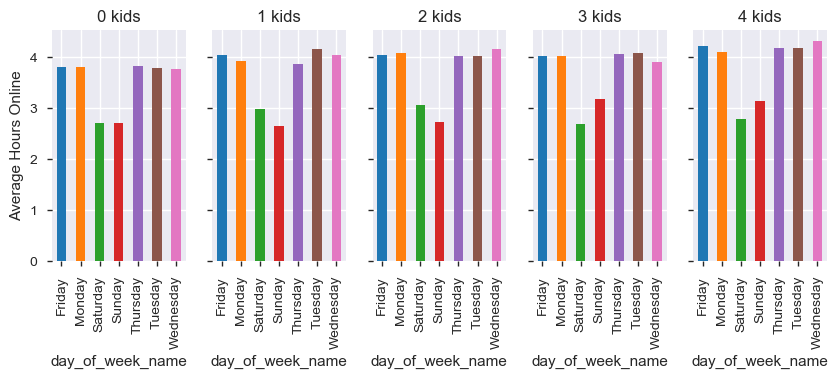

In [589]:
fig, ax = plt.subplots(1, 5, sharex='col', sharey='row')
for i in range(5):
    tmp[tmp.number_of_kids==i].plot(kind='bar',x = 'day_of_week_name',y = 'online_hours',title= (str(i)+ ' kids'), ax = ax[i],figsize=(10,3),legend=False )
    ax[i].set_ylabel('Average Hours Online')


### Distribution of drivers with kids

In [522]:
avg_hours_given_kids_0 = df2.groupby(['driver_id','number_of_kids'], as_index=False).agg({'online_hours':'mean'})
avg_hours_given_kids_0['online_hours'] = avg_hours_given_kids_0['online_hours']

In [523]:
avg_hours_given_kids_0.head()

,driver_id,number_of_kids,online_hours
0,111556,4,1.531349
1,111575,0,3.348016
2,111779,0,1.576786
3,111839,0,6.106746
4,112486,1,1.885913


In [524]:
avg_hours_given_kids_0['number_of_kids'].value_counts()

0    1103
3     353
1     351
4     350
2     320
Name: number_of_kids, dtype: int64

In [525]:
tmp = avg_hours_given_kids_0

### What is the distribution of hours online by number of kids?

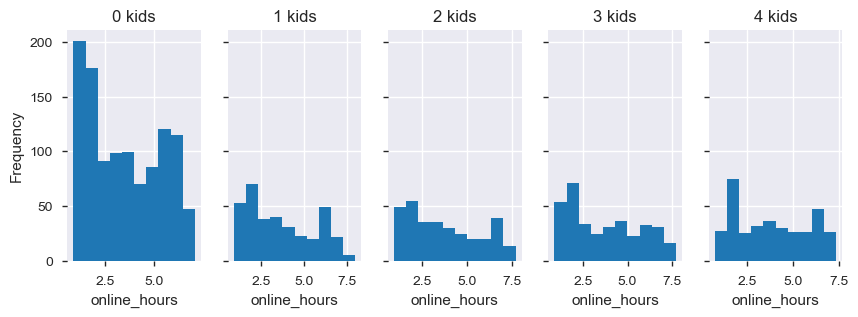

In [526]:
fig, ax = plt.subplots(1, 5, sharex='col', sharey='row')
for i in range(5):
    tmp[tmp.number_of_kids==i]['online_hours'].plot(kind='hist',title= (str(i)+ ' kids'), ax = ax[i],figsize=(10,3) )
    ax[i].set_xlabel('online_hours')


   number_of_kids  online_hours
0               0      3.491123
1               1      3.669882
2               2      3.738615
3               3      3.710639
4               4      3.847422


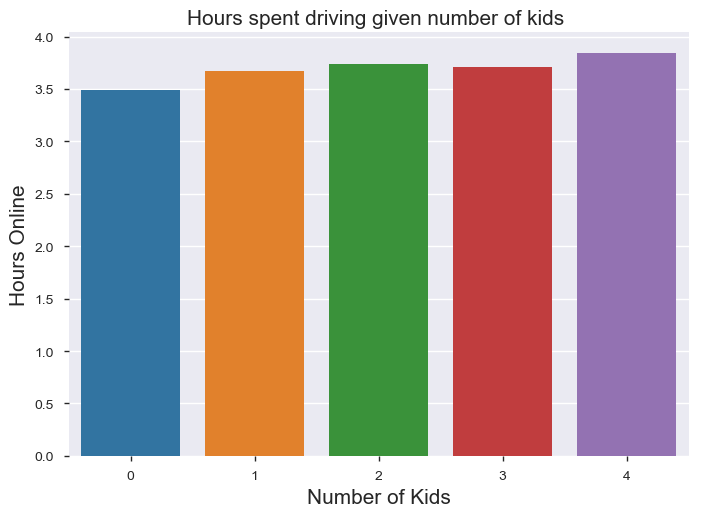

In [527]:
avg_hours_given_kids = avg_hours_given_kids_0.groupby(['number_of_kids'], as_index=False).agg({'online_hours':'mean'})
print(avg_hours_given_kids)
sns.barplot(x='number_of_kids', y='online_hours', data=avg_hours_given_kids)
plt.title ('Hours spent driving given number of kids ', fontsize=15);
plt.xlabel('Number of Kids', fontsize=15);
plt.ylabel('Hours Online', fontsize=15);

# Feature Transformation

In [528]:
# easier name
df = df2

In [529]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52017 entries, 0 to 52016
Data columns (total 8 columns):
date                52017 non-null object
driver_id           52017 non-null int64
gender              52017 non-null int64
age                 52017 non-null int64
number_of_kids      52017 non-null int64
online_hours        52017 non-null float64
day_of_week         52017 non-null int64
day_of_week_name    52017 non-null object
dtypes: float64(1), int64(5), object(2)
memory usage: 3.2+ MB


In [530]:
#Transform date to a numeric data type
df['date'] = pd.to_datetime(df['date'])
df['date_ord'] = df['date'].map(dt.datetime.toordinal)

In [531]:
df.head()

,date,driver_id,gender,age,number_of_kids,online_hours,day_of_week,day_of_week_name,date_ord
0,2017-06-01,111556,0,49,4,1.820833,3,Thursday,736481
1,2017-06-02,111556,0,49,4,2.050000,4,Friday,736482
2,2017-06-03,111556,0,49,4,0.000000,5,Saturday,736483
3,2017-06-04,111556,0,49,4,0.000000,6,Sunday,736484
4,2017-06-05,111556,0,49,4,3.812500,0,Monday,736485


# Drop unecessary columns

In [532]:
df.drop(columns=['date','date_ord','day_of_week_name'],inplace=True)

In [533]:
df.head()

,driver_id,gender,age,number_of_kids,online_hours,day_of_week
0,111556,0,49,4,1.820833,3
1,111556,0,49,4,2.050000,4
2,111556,0,49,4,0.000000,5
3,111556,0,49,4,0.000000,6
4,111556,0,49,4,3.812500,0


### Export df

In [534]:
df.to_csv('../data/df3.csv',index=False)

In [535]:
df = pd.read_csv('../data/df3.csv')

# Train test split on train data

In [536]:
features = df.loc[:, df.columns != 'online_hours']
#Try dropping date_ord
# features.drop('date_ord',axis = 1, inplace=True)

target = df['online_hours']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size =0.3,
                                                    random_state = 7)

In [537]:
features.head()

,driver_id,gender,age,number_of_kids,day_of_week
0,111556,0,49,4,3
1,111556,0,49,4,4
2,111556,0,49,4,5
3,111556,0,49,4,6
4,111556,0,49,4,0


### Perform scaling to bring values to normalized scale (0-1)

In [538]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelling

### Using Sklearn

### Linear Regression

In [539]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [541]:
y_pred = regressor.predict(X_test)
# y_pred = [int(round(i)) for i in y_pred]
r2 = regressor.score(X_test, y_test)
r3 = r2*100
print('Linear Regression R squared": %.4f' % r2)
print( '%.2f percent of the variability in Y can be explained using X' % r3)

Linear Regression R squared": 0.1095
10.95 percent of the variability in Y can be explained using X


In [542]:
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 2.5666


### Gradient boosting

In [543]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor(random_state=0)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [544]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared": 0.1732


In [545]:
y_pred = model.predict(X_test)
# y_pred = [round(i) for i in y_pred]
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 2.4731


### Random Forest

In [546]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=0)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [547]:
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared": 0.5523


In [548]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 1.8199


In [549]:
r2_list = [forest_reg.score(X_test, y_test), model.score(X_test, y_test),regressor.score(X_test, y_test)]
rmse_list = [forest_rmse,model_rmse,lin_rmse]
model_name = ['random forest','gradient boosting','linear regression']
model_df = pd.DataFrame({'r2': r2_list,'rmse':rmse_list,'model_name': model_name})
# model_df = model_df.set_index('model_name')

In [550]:
model_df

,r2,rmse,model_name
0,0.552287,1.819861,random forest
1,0.173196,2.473090,gradient boosting
2,0.109509,2.566571,linear regression


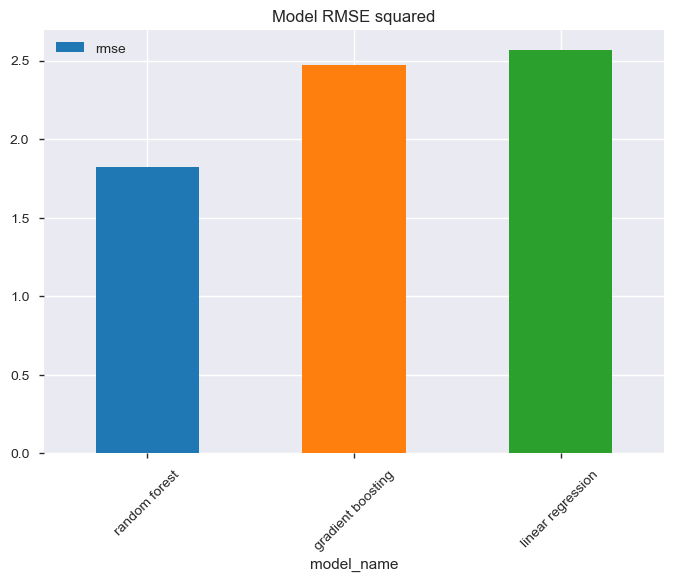

In [592]:
model_df.plot(x = 'model_name',y='rmse', kind = 'bar', title = 'Model RMSE squared', rot = 45)

Random forest regressor performed the best in terms of RMSE and R2 

### Now lets do Random Search with Random Forest regressor to find optimal hyperparameters

In [552]:
####
from sklearn.model_selection import RandomizedSearchCV
cv = 10
n_jobs = 3
n_iter = 50
RF = RandomForestRegressor(random_state=0)
parameters = {'n_estimators':(10,20,30,40,50,60),
              'max_features': ('sqrt','auto'),
              'max_depth':(5,10,20,50,100,250,500),
               'bootstrap': (True, False),
               'min_samples_split': [10, 20, 30,40,50]}
RF = RandomizedSearchCV(RF, parameters,cv=cv,n_jobs=n_jobs,n_iter=n_iter,random_state=0)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
# y_pred = [round()i for i in y_pred]
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 1.8040


In [553]:
rf_params = RF.best_params_

In [554]:
RF = RandomForestRegressor(**rf_params, random_state=0 )
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 1.8040


### Random search for GBM

In [555]:
# Get parameters for GBM 
GBM = ensemble.GradientBoostingRegressor(random_state=0)
GBM.get_params().keys()

dict_keys(['alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [556]:
cv = 10
n_jobs = 3
n_iter = 50
GBM = ensemble.GradientBoostingRegressor(random_state=0)
parameters = {'n_estimators':(10,20,30,40,50,60),
              'max_features': ('sqrt','auto'),
              'max_depth':(5,10,20,50,100,250,500),
               'min_samples_split': [10, 20, 30,40,50]}
GBM = RandomizedSearchCV(GBM, parameters,cv=cv,n_jobs=n_jobs,n_iter=n_iter,random_state=0)
GBM.fit(X_train, y_train)
y_pred = GBM.predict(X_test)
# y_pred = [round()i for i in y_pred]
GBM_mse = mean_squared_error(y_pred, y_test)
GBM_rmse = np.sqrt(GBM_mse)
print('GBM RMSE: %.4f' % GBM_rmse)

GBM RMSE: 1.7477


In [557]:
gbm_params = GBM.best_params_

In [558]:
gbm = ensemble.GradientBoostingRegressor(**gbm_params,random_state=0)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
gbm_mse = mean_squared_error(y_pred, y_test)
gbm_rmse = np.sqrt(gbm_mse)
print('GBM RMSE: %.4f' % gbm_rmse)

GBM RMSE: 1.7477


# We can also use Tpot to give us the best model

In [1299]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2)
tpot.fit(X_train, y_train) 

Generation 1 - Current best internal CV score: -3.9482743834802414
Generation 2 - Current best internal CV score: -3.9376169951871645
Generation 3 - Current best internal CV score: -3.9291577184943733
Generation 4 - Current best internal CV score: -3.9291577184943733
Generation 5 - Current best internal CV score: -3.9291577184943733

Best pipeline: DecisionTreeRegressor(XGBRegressor(input_matrix, learning_rate=0.01, max_depth=8, min_child_weight=8, n_estimators=100, nthread=1, subsample=0.9000000000000001), max_depth=7, min_samples_leaf=8, min_samples_split=18)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=5,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=20,
       random_state=None, scoring=None, subsample=1.0, use_dask=False,
       verbosity=2, warm_start=False)

In [1300]:
#Tpot shows negative MSE
print("TPOT cross-validation RMSE")
print(np.sqrt(abs(tpot.score(X_test, y_test))))

TPOT cross-validation RMSE
1.9691444973299015


In [1301]:
#Using sklearns MSE
print('RMSE:')
print(np.sqrt(mean_squared_error(y_test, tpot.predict(X_test))))

RMSE:
1.9691444973299015


### Export this final tpot with pipeline

In [226]:
# NOTE: Make sure that the class is labeled 'target' in the data file
tpot.export('tpot_gojek_pipeline_main.py')

True

# How can we improve the model?
- Feature selection through removing collinear variables

### Feature importance (Using tuned random forest regressor model from randomized search)

In [283]:
features.columns

Index(['driver_id', 'gender', 'age', 'number_of_kids', 'day_of_week',
       'date_ord'],
      dtype='object')

In [1378]:
forest_reg = RandomForestRegressor(**RF.best_params_,random_state=0 )
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=50,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [593]:
importance = RF.feature_importances_
feature_indexes_by_importance = importance.argsort()
names = []
score = []
for index in feature_indexes_by_importance:

    names.append(features.columns[index])
    score.append((importance[index] *100.0))

feature_df = pd.DataFrame({'feature':names,'score':score}).sort_values('score',ascending=False)
feature_df

,feature,score
4,driver_id,49.246176
3,age,20.748174
2,day_of_week,12.189674
1,gender,11.017000
0,number_of_kids,6.798976


# Remove correlated features (if needed)

Text(0.5, 1.0, 'Correlation Matrix of variables')

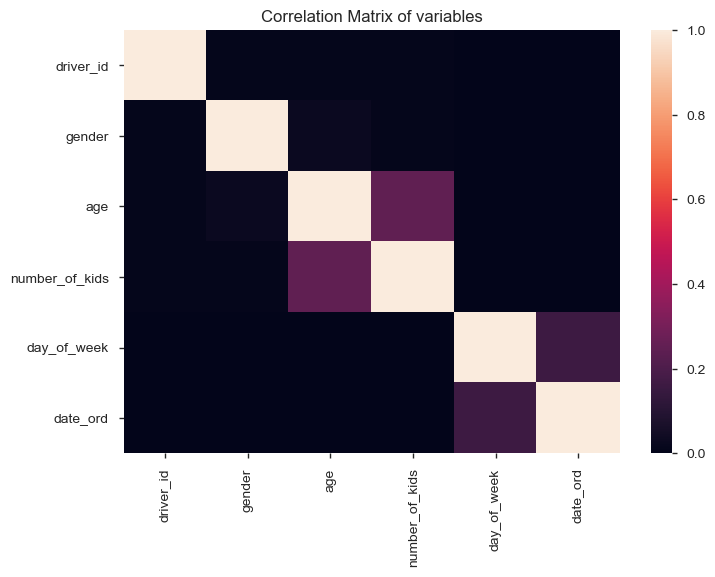

In [285]:
# Create correlation matrix
corr_matrix = features.corr().abs()

sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
plt.title("Correlation Matrix of variables")

In [290]:
threshold = 0.5
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
print(upper)
# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop features 
if len(to_drop) > 0:
    print("Columns that should be dropped: %s" %to_drop[0])
else:
    print("No Columns to drop")

                driver_id    gender       age  number_of_kids  day_of_week  \
driver_id             NaN  0.008018  0.008218        0.008844     0.000028   
gender                NaN       NaN  0.029463        0.008984     0.000333   
age                   NaN       NaN       NaN        0.247013     0.000006   
number_of_kids        NaN       NaN       NaN             NaN     0.000535   
day_of_week           NaN       NaN       NaN             NaN          NaN   
date_ord              NaN       NaN       NaN             NaN          NaN   

                date_ord  
driver_id       0.000255  
gender          0.001655  
age             0.000408  
number_of_kids  0.000439  
day_of_week     0.162689  
date_ord             NaN  
No Columns to drop


# Evaluate on test. But first, transform test to include driver data

In [451]:
test2 = test2.sort_values(['driver_id', 'date'], ascending=[True, True])

In [559]:
test2.head()

,driver_id,date,online_hours,gender,age,number_of_kids,day_of_week
0,111556,2017-06-22,2,0,49,4,3
1,111556,2017-06-23,5,0,49,4,4
2,111556,2017-06-24,0,0,49,4,5
3,111556,2017-06-25,0,0,49,4,6
4,111556,2017-06-26,0,0,49,4,0


In [453]:
#Convert date to an integer using ordinal
test2['date'] = pd.to_datetime(test2['date'])

test2['day_of_week'] = test2.date.dt.dayofweek
# test2['date_ord'] = test2['date'].map(dt.datetime.toordinal)

# convert gender to category
test2['gender'] = test2['gender'].map( {'MALE':1, 'FEMALE':0} )


test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17458 entries, 181 to 12348
Data columns (total 7 columns):
driver_id         17458 non-null int64
date              17458 non-null datetime64[ns]
online_hours      17458 non-null int64
gender            17458 non-null int64
age               17458 non-null int64
number_of_kids    17458 non-null int64
day_of_week       17458 non-null int64
dtypes: datetime64[ns](1), int64(6)
memory usage: 1.1 MB


In [454]:
test2.head()

,driver_id,date,online_hours,gender,age,number_of_kids,day_of_week
181,111556,2017-06-22,2,0,49,4,3
180,111556,2017-06-23,5,0,49,4,4
179,111556,2017-06-24,0,0,49,4,5
178,111556,2017-06-25,0,0,49,4,6
177,111556,2017-06-26,0,0,49,4,0


In [560]:
test2.to_csv('../data/test2.csv',index=False)

In [456]:
test2 = pd.read_csv('../data/test2.csv')

In [561]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17458 entries, 0 to 17457
Data columns (total 7 columns):
driver_id         17458 non-null int64
date              17458 non-null object
online_hours      17458 non-null int64
gender            17458 non-null int64
age               17458 non-null int64
number_of_kids    17458 non-null int64
day_of_week       17458 non-null int64
dtypes: int64(6), object(1)
memory usage: 954.8+ KB


### Perform feature engineering for test2 to get same variables as train data

In [562]:
test2.head()

,driver_id,date,online_hours,gender,age,number_of_kids,day_of_week
0,111556,2017-06-22,2,0,49,4,3
1,111556,2017-06-23,5,0,49,4,4
2,111556,2017-06-24,0,0,49,4,5
3,111556,2017-06-25,0,0,49,4,6
4,111556,2017-06-26,0,0,49,4,0


In [563]:
# drop unecessary columns in test2
test2.drop(columns=["date"],inplace=True)
test2.head()

,driver_id,online_hours,gender,age,number_of_kids,day_of_week
0,111556,2,0,49,4,3
1,111556,5,0,49,4,4
2,111556,0,0,49,4,5
3,111556,0,0,49,4,6
4,111556,0,0,49,4,0


In [578]:
df.head()

,driver_id,gender,age,number_of_kids,online_hours,day_of_week
0,111556,0,49,4,1.820833,3
1,111556,0,49,4,2.050000,4
2,111556,0,49,4,0.000000,5
3,111556,0,49,4,0.000000,6
4,111556,0,49,4,3.812500,0


In [579]:
df.columns

Index(['driver_id', 'gender', 'age', 'number_of_kids', 'online_hours',
       'day_of_week'],
      dtype='object')

In [564]:
#make sure ordering of cols in test2 is similiar to df.
test2 = test2[df.columns]
# test2 = test2.sort_values(['driver_id', 'date_ord'], ascending=[True, True])
test2.head()

,driver_id,gender,age,number_of_kids,online_hours,day_of_week
0,111556,0,49,4,2,3
1,111556,0,49,4,5,4
2,111556,0,49,4,0,5
3,111556,0,49,4,0,6
4,111556,0,49,4,0,0


In [565]:
test2_features = test2.loc[:, test2.columns != 'online_hours']
test2_target = test2['online_hours']

In [566]:
test2_features.head()

,driver_id,gender,age,number_of_kids,day_of_week
0,111556,0,49,4,3
1,111556,0,49,4,4
2,111556,0,49,4,5
3,111556,0,49,4,6
4,111556,0,49,4,0


In [567]:
features.head()

,driver_id,gender,age,number_of_kids,day_of_week
0,111556,0,49,4,3
1,111556,0,49,4,4
2,111556,0,49,4,5
3,111556,0,49,4,6
4,111556,0,49,4,0


### Scale new test data on scaler fitted on the train data

In [568]:
### applying scaling without ordering the features will cause different scaling to wrong features
test2_features = test2_features.loc[:,test2_features.columns]
test2_features = scaler.transform(test2_features)

# Evaluate RF model on the new test set

In [569]:
#### Using the Random search model in prediction
y_pred = RF.predict(test2_features)
forest_mse = mean_squared_error(y_pred, test2_target)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 2.3676


# Train the model on the entire Train dataset now

In [570]:
df.head()

,driver_id,gender,age,number_of_kids,online_hours,day_of_week
0,111556,0,49,4,1.820833,3
1,111556,0,49,4,2.050000,4
2,111556,0,49,4,0.000000,5
3,111556,0,49,4,0.000000,6
4,111556,0,49,4,3.812500,0


In [319]:
# df.drop('date_ord',axis=1,inplace=True)

In [571]:
#X_train
X_train_new = df.loc[:, ~df.columns.isin(['online_hours'])]
#y_train
y_train_new = df['online_hours']
#X_test
test2_features_new = test2.loc[:, ~test2.columns.isin(['online_hours'])]
#y_test
test2_target_new = test2['online_hours']

#Scale
scaler = MinMaxScaler()
X_train_new = scaler.fit_transform(X_train_new)
test2_features_new = scaler.transform(test2_features_new)

In [577]:
joblib.dump(scaler, 'scaler.pkl', compress=9)

['scaler.pkl']

In [572]:
cv = 10
n_jobs = 3
n_iter = 50
RF2 = RandomForestRegressor(random_state=0)
parameters = {'n_estimators':(10,20,30,40,50,60),
              'max_features': ('sqrt','auto'),
              'max_depth':(5,10,20,50,100,250,500),
               'bootstrap': (True, False),
               'min_samples_split': [10, 20, 30,40,50]}
RF2 = RandomizedSearchCV(RF2, parameters,cv=cv,n_jobs=n_jobs,n_iter=n_iter,random_state=0)
RF2.fit(X_train_new, y_train_new)
y_pred = RF2.predict(test2_features_new)
forest_mse = mean_squared_error(y_pred, test2_target_new)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 3.2523


In [576]:
from sklearn.externals import joblib
joblib.dump(RF2, 'RF2.pkl', compress=9)

['RF2.pkl']

3.2454

In [573]:
RF2.best_params_

{'n_estimators': 30,
 'min_samples_split': 30,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': True}

In [574]:
print('Random Forest R Squared: %.4f' %abs(RF2.score(test2_features_new, test2_target_new)))

Random Forest R Squared: 0.0759


### With Tpot

In [1341]:
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2)
tpot.fit(X_train_new, y_train_new)
print("TPOT cross-validation RMSE")
print(np.sqrt(abs(tpot.score(test2_features_new, test2_target_new))))

Generation 1 - Current best internal CV score: -4.055028809649468


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ElasticNetCV(XGBRegressor(input_matrix, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=100, nthread=1, subsample=1.0), l1_ratio=0.9500000000000001, tol=0.01)
TPOT cross-validation RMSE
4.796190162123389


In [1019]:
#Using sklearns MSE
print('RMSE:')
print(np.sqrt(mean_squared_error(test2_target_new, tpot.predict(test2_features_new))))

RMSE:
3.7502214189517824
